# Neural Ordinary Differential Equations

Ordinary differential equation is of the form: 

$$
\frac{dz}{dt} = f(z(t), t) \tag{1}
$$
$$
\{(z_0, t_0),(z_1, t_1),...,(z_M, t_M)\} - \text{observations}
$$

In the paper, it is objective to find an approximation $\widehat{f}(z, t, \theta)$ of dynamics function $f(z, t)$. 


First, consider a somewhat simpler task: there are only 2 observations, at the beginning and at the end of the trajectory, $(z_0, t_0), (z_1, t_1)$. One starts the evolution of the system from $z_0, t_0$ for time $t_1 - t_0$ with some parameterized dynamics function using any ODE initial value solver. After that, one ends up being at some new state $\hat{z_1}, t_1$, compares it with the observation $z_1$, and tries to minimize the difference by varying the parameters $\theta$.

we consider optimizing the following loss function $L(\hat{z_1})$:

$$
L(z(t_1)) = L \Big( \int_{t_0}^{t_1} f(z(t), t, \theta)dt \Big) = L \big( \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big) \tag{2}
$$

To optimize $L$ one needs to compute the gradients wrt. its parameters: $z(t_0), t_0, t_1, \theta$. To do this let us first determine how loss depends on the state at every moment of time $(z(t))$:
$$
a(t) = -\frac{\partial L}{\partial z(t)} \tag{3}
$$
$a(t)$ is called *adjoint*, its dynamics is given by another ODE:

$$
\frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} \tag{4}
$$

One can then compute 
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{5}
$$

An augmented state is for example of this neural ODE: 
$$
\frac{d}{dt} \begin{bmatrix} z \\ \theta \\ t \end{bmatrix} (t) = f_{\text{aug}}([z, \theta, t]) := \begin{bmatrix} f([z, \theta, t ]) \\ 0 \\ 1 \end{bmatrix} \tag{6}
$$

Adjoint state to this augmented state is then
$$
a_{\text{aug}} := \begin{bmatrix} a \\ a_{\theta} \\ a_t \end{bmatrix}, a_{\theta}(t) := \frac{\partial L}{\partial \theta(t)}, a_t(t) := \frac{\partial L}{\partial t(t)} \tag{7}
$$

Gradient of the augmented dynamics

$$
\frac{\partial f_{\text{aug}}}{\partial [z, \theta, t]} = \begin{bmatrix} 
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix} \tag{8}
$$

Adjoint state ODE from formula (4) is then 
$$
\frac{d a_{\text{aug}}}{dt} = - \begin{bmatrix} a\frac{\partial f}{\partial z} & a\frac{\partial f}{\partial \theta} & a\frac{\partial f}{\partial t}\end{bmatrix} \tag{9}
$$

By solving this adjoint augmented ODE initial value problem one gets
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{10}
$$

$$
\frac{\partial L}{\partial \theta} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt \tag{11}
$$

$$
\frac{\partial L}{\partial t_0} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt \tag{12}
$$

which, together with,
$$
\frac{\partial L}{\partial t_1} = - a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} \tag{13}
$$
complements gradients wrt. all the ODESolve parameters.

The gradients (10), (11), (12), (13) can be calculated altogether during a single call of the ODESolve with augmented state dynamics (9).

# Implementation 

This is very close to what is actually implemented in authors' [repository](https://github.com/rtqichen/torchdiffeq). 

In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

Implementation of an ordinary differential equation initial value solver (IVP).

In [2]:
def ode_solve(z0, t0, t1, f):
    """
    Euler ODE initial value solver
    """
    h_max = 0.05 # step size. 
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

** Algorithm 1: Reverse-mode derivative of an ODE IVP **

*  Input: parameters $\theta$, start time $t_0$, stop time $t_1$, final state $z(t_1)$, loss gradient $\frac{\partial L}{\partial z(t_1)}$ 

* 1. $\frac{\partial{L}}{\partial t_1} = (\frac{\partial L}{\partial z(t_1)})^{T}  f(z(t_1), t_1, \theta)$ Compute gradient w.r.t $t_1$ 

* 2. $s_0 = [z(t_1), \frac{\partial L}{\partial z(t_1)}, 0, - \frac{\partial L}{\partial t_1}   ]$ : define initial states. 

* 3. Define dynamics on augmented state $\text{aug_dynamics}([z(t), a(t), -, - ], t, \theta)$ 
       * return $[f(z(t), t, \theta), - a(t)^{T} \frac{\partial f}{\partial z}, - a(t)^{T} \frac{\partial f}{\partial \theta}, - a(t)^{T} \frac{\partial f}{\partial t} ]$ . This is to concatenate time-derivatives. 

* Solve the reverse-time ODE: 

$$
[z(t_0), \frac{\partial L}{\partial z(t_0) }, \frac{\partial L}{\partial \theta} , \frac{\partial L}{\partial t_0} ] = ODESolve(s_0, \text{aug_dynamics}, t_1, t_0, \theta)
$$

* Output: return $\frac{\partial L}{\partial z(t_0)}, \frac{\partial L}{\partial \theta}, \frac{\partial L}{\partial t_0}, \frac{\partial L}{\partial t_1}$



We also implement a  parameterized dynamics function in the form of neural network with a couple useful methods: 

* First, we need to flatten all the parameters that the function depends on.

* Second, we need to implement third step which is to concatenate the time-derivatives. The augmented dynamics depend on the gradient of the function wrt to the inputs and parameters. We will use **torch.autograd.grad** method.

In [3]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        ## Set up the Initial State ## 
        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # autograd.grad returns None if no gradient, 
        
        # grad method automatically sums gradients for batch items, 
        # we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0) # concatenate the time-derivatives 
            adfdp = adfdp.expand(batch_size, -1) / batch_size # divide by batch-size to avoid overfitting. 
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size 
        return out, adfdz, adfdt, adfdp
    
    # flatten parameters: 
    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

The code below is the forward and backward passes of *Neural ODE*: 
* We separate it from main ***torch.nn.Module*** because custom backward function can't be implemented inside Module, but can be implemented inside ***torch.autograd.Function***.

In [4]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func) # solve the ODE forward. 
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        ## Set up backward ODE func ## 

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            # Dynamics of the original system augmented with
            # the adjoint wrt z, and an integrator wrt t and args. 
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore gradients wrt time and parameters. 

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                # autograd.grad returns None if no gradient, set to zero. 
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1) # concatenate time derivatives. 

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)
            
            ###########################
            ## Solve the Adjoint ODE ##
            ###########################
            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Run the augmented system backwards in time. 
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]  
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params] # update any gradients wrt state at this time point
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:] # extract just the t[i-1] value 

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]
            
            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0

        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Wrap ode adjoint function in **nn.Module** for convenience.

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        # apply the adjoint to the state: 
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Application

## _Learning true dynamics function (proof of concept)_

To test this we will specify an ODE, evolve it and sample points on its trajectory, and then restore it.

We test a simple linear ODE system. 

$$
\frac{dz}{dt} = \begin{bmatrix}
                    -.1 & -1\\
                    1 & -.1\\
                    \end{bmatrix} z
$$

with $z_0 = [0.1, 0.3]^{T}$

Trained function here is also a simple matrix.

In [6]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

Dynamics is simply given with a matrix.

In [7]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        ## Set the linear dynamics system: 
        super(SpiralFunctionExample, self).__init__(Tensor([[-.1, -1.], [1., -.1]]))

Initial random linear dynamics function to be optimized

In [8]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

 Initialize the parameters and Forward Pass: 

In [9]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

In [10]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [11]:
# convert back to numpy: 
def to_np(x):
    return x.detach().cpu().numpy()

Plotting the trajectories: 

In [12]:
# function to plot the trajectories: 
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.cividis)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [13]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.1, 0.2]])) # initial condition. 

    t_max = 6.29*5
    n_points = 100

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps+1):
        obs_, ts_ = create_batch() # target. 
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True) # output. 
        # taking an optimization step: 
        loss = F.mse_loss(z_, obs_.detach()) # mean squared error loss: pred z and target. 
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # skipping by frequency: plot and save only this result. 
        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            print('Iter {:01d} | Total Loss {:.6f}'.format(i, loss)) ## print some necessary information
            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"./assets/imgs/{name}/{i}.png")
            clear_output(wait=True)

In [14]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

Iter 500 | Total Loss 0.000274


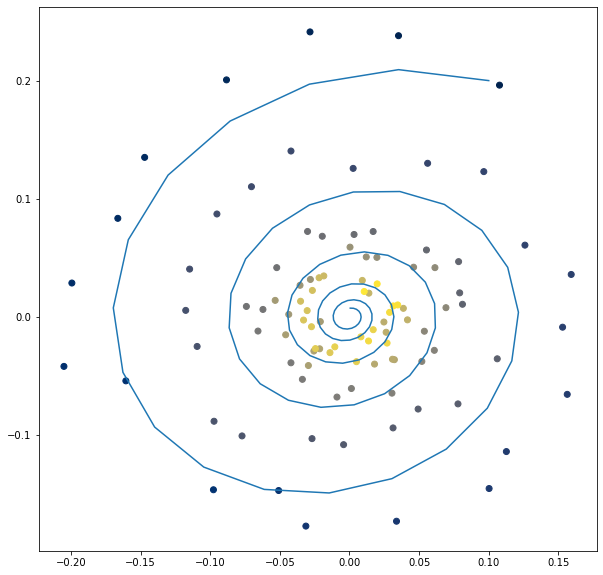

In [16]:
conduct_experiment(ode_true, ode_trained,500, "linear")

* Neural ODEs can approximate dynamics.

## Generative latent function time-series model

In this section we will experiment with generating continuous sequential data using Neural ODE and exploring its latent space a bit. The approach here is slightly different from the corresponding example in authors repository, the one here has a more diverse set of trajectories.

### Data

Training data consists of random spirals, one half of which is clockwise and another is counter-clockwise. Then, random subtimespans of size 100 are sampled from these spirals, having passed through encoder rnn model in reversed order yielding a latent starting state, which then evolves creating a trajectory in the latent space. This latent trajectory is then mapped onto the data space trajectory and compared with the actual data observations. 

### VAE as a generative model

This is a summary of  generative model through sampling procedure from the paper:
$$
z_{t_0} \sim \mathcal{N}(0, I)
$$

$$
z_{t_1}, z_{t_2},...,z_{t_M} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_M)
$$

$$
\text{each } x_{t_i} \sim p(x \mid z_{t_i};\theta_x)
$$

Which can be trained using variational autoencoder approach:

1. Run the RNN encoder through the time series backwards in time to infer the parameters $\mu_{z_{t_0}}$, $\sigma_{z_{t_0}}$ of variational posterior and sample from it
$$
z_{t_0} \sim q \left( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q \right) = \mathcal{N} \left(z_{t_0} \mid \mu_{z_{t_0}} \sigma_{z_{t_0}} \right)
$$
2. Obtain the latent trajectory 
$$
z_{t_1}, z_{t_2},...,z_{t_N} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_N), \text{ where } \frac{d z}{d t} = f(z, t; \theta_f)
$$
3. Map the latent trajectory onto the data space using another neural network: $\hat{x_{t_i}}(z_{t_i}, t_i; \theta_x)$
4. Maximize Evidence Lower BOund estimate for sampled trajectory
$$
\text{ELBO} \approx N \Big( \sum_{i=0}^{M} \log p(x_{t_i} \mid z_{t_i}(z_{t_0}; \theta_f); \theta_x) + KL \left( q( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q) \parallel \mathcal{N}(0, I) \right) \Big)
$$
And in case of Gaussian posterior $p(x \mid z_{t_i};\theta_x)$ and known noise level $\sigma_x$
$$
\text{ELBO} \approx -N \Big( \sum_{i=1}^{M}\frac{(x_i - \hat{x_i} )^2}{\sigma_x^2} - \log \sigma_{z_{t_0}}^2 + \mu_{z_{t_0}}^2 + \sigma_{z_{t_0}}^2 \Big) + C
$$

One can then test how this model extrapolates the trajectory from only its initial moment observations.

### Defining the models

* RNN-Encoder from original paper; forward pass: 

In [17]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var

* Neural-ODE Decoder:

In [18]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        #######
        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [19]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p

### Generating dataset

In [29]:
t_max = 10
n_points = 50
noise_std = 0.05 ## add noise to the original trajectories in the sample. 

num_spirals = 50

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

* Plot of the generating dataset. 

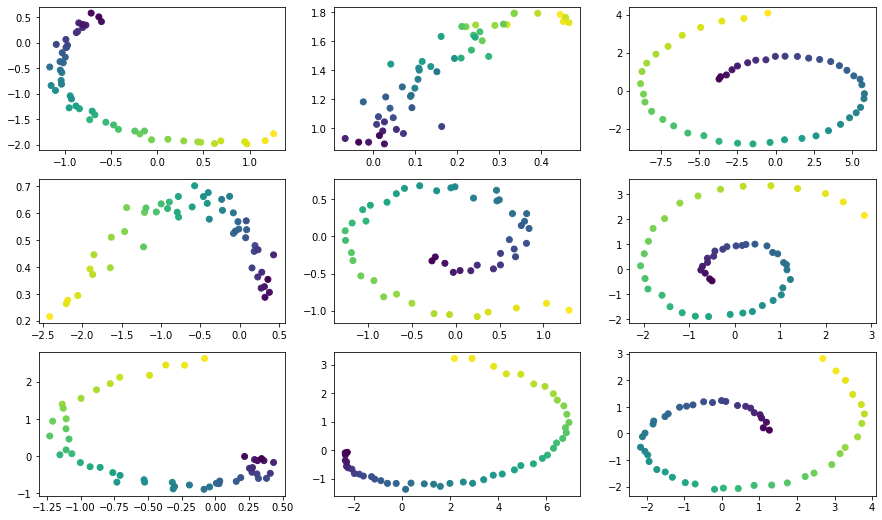

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.viridis_r)
plt.show()

In [31]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=45):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Training

In [32]:
vae = ODEVAE(2, 64, 6)
vae = vae.cuda()
if use_cuda:
    vae = vae.cuda()

* Optimizer method: Adam. 

In [33]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

* Training part: 

----Training Progress----

Iteration 2000 | Total Loss 16.520916

-------------------------



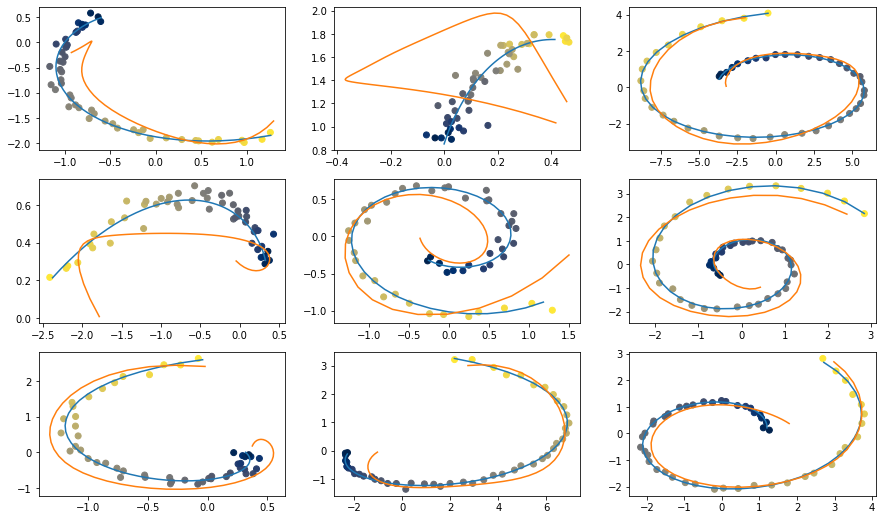

In [36]:
preload = False
#preload = True # to reload the spirals in the models folder. 
n_epochs = 2000
batch_size = 50

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

for epoch_idx in range(n_epochs+1):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])
        x, t = x[permutation], t[permutation]
        ## Step 4 in the progress. 
        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())
        if epoch_idx % 10 ==0:
            print('----Training Progress----\n')
            print('Iteration {:01d} | Total Loss {:5f}'.format(epoch_idx, loss))
            print('\n-------------------------\n')
            frm, to, to_seed = 0, 200, 50
            seed_trajs = samp_trajs[frm:to_seed]
            ts = samp_ts[frm:to]
            if use_cuda:
                seed_trajs = seed_trajs.cuda()
                ts = ts.cuda()
            samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))
            ### Create subplots: 
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
            axes = axes.flatten()
            for i, ax in enumerate(axes):
                ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts                                       [frm:to_seed, i, 0]), cmap=cm.cividis_r)
                ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
                ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
            plt.show()
            clear_output(wait=True)

* Dots are observations of the trajectories (blue). Color of the dots represents the time. Yellow lines are reconstructed and interpolated trajectories using dots as inputs. 

* This is to produce analogous trajectories as in the figures 8 and 9 in the original paper in the section 5. 


* Reconstructions of examples are not very good indeed. Maybe the model is not complex enough or have not been trained for enough time (number of training epochs is 1000). 

## Reference 

   - [Original paper](https://arxiv.org/abs/1806.07366)
   - [Authors' PyTorch implementation](https://github.com/rtqichen/torchdiffeq)
   - [Variational Inference](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)